In [1]:
# Adapted and extension of Data100 assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ds100_utils import *

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

def horiz_concat_df(dict_of_df, head=None):
    """
    Horizontally concatenante multiple dataframes for easier visualization. 
    Each dataframe must have the same columns.
    """
    df = pd.concat([df.reset_index(drop=True) for df in dict_of_df.values()], axis=1, keys=dict_of_df.keys())
    if head is None:
        return df
    return df.head(head)

---
# Tweet Analysis using Twitter's API

I scraped several high public figures' tweets from their Twitter. I obtained the data from using Twitter's API. In order to do so, I needed to make a Twitter developer account. The data of those figures is stored in a folder called `tweeters`.


The public figures we will be investigating are:
- House Representative, [Alexandria Ocasio-Cortez @aoc](https://twitter.com/aoc)
- U.S Senator, [Bernie Sanders @berniesanders](https://twitter.com/berniesanders)
- Business Magnate, [Bill Gates @billgates](https://twitter.com/billgates)
- Business Mogul, [Elon Musk @elonmusk](https://twitter.com/elonmusk)
- Portugese Soccer Player, [Cristiano Ronaldo @cristiano](https://twitter.com/cristiano)
- President of France, [Emmanuel Macron @emmanuelmacron](https://twitter.com/emmanuelmacron)

# Importing the Data

The format of the data is in JavaScript Object Notation (JSON). `tweets` will be a dictionary where the keys are the public figures and the values will be their individual dataframes.

In [2]:
tweets = {
    "aoc": pd.read_json(path_or_buf = "tweeters/AOC_recent_tweets.txt").set_index('id'),
    "cristiano": pd.read_json(path_or_buf = "tweeters/Cristiano_recent_tweets.txt").set_index('id'),
    "elon": pd.read_json(path_or_buf = "tweeters/elonmusk_recent_tweets.txt").set_index('id'),
    "gates": pd.read_json(path_or_buf = "tweeters/BillGates_recent_tweets.txt").set_index('id'),
    "macron": pd.read_json(path_or_buf = "tweeters/EmmanuelMacron_recent_tweets.txt").set_index('id'),
    "sanders": pd.read_json(path_or_buf = "tweeters/BernieSanders_recent_tweets.txt").set_index('id'), 
}

### Let's take a look at what our dataframes looks like.

In [3]:
tweets['aoc'].head()

,created_at,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
id,,,,,,,,,,,,,,,,,,,,,
1358149122264563712,2021-02-06 20:22:38+00:00,1358149122264563712,RT @RepEscobar: Our country has the moral obligation and responsibility to reunite every single family separated at the southern border.\n\nT…,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'RepEscobar', 'name': 'Rep. Veronica Escobar', 'id': 1075517806551154689, 'id_str': '1075517806551154689', 'indices': [3, 14]}], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1358147616400408576,2021-02-06 20:16:39+00:00,1358147616400408576,RT @RoKhanna: What happens when we guarantee $15/hour?\n\n💰 31% of Black workers and 26% of Latinx workers get raises.\n😷 A majority of essent…,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'RoKhanna', 'name': 'Ro Khanna', 'id': 771152516, 'id_str': '771152516', 'indices': [3, 12]}], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1358145332316667909,2021-02-06 20:07:35+00:00,1358145332316667904,(Source: https://t.co/3o5JEr6zpd),False,"[0, 33]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/3o5JEr6zpd', 'expanded_url': 'https://www.thestate.com/news/politics-government/election/article246484780.html', 'display_url': 'thestate.com/news/politics-…', 'indices': [9, 32]}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1.358145e+18,1.358145e+18,138203134.0,...,1026,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN
1358145218407759875,2021-02-06 20:07:07+00:00,1358145218407759872,"Joe Cunningham pledged to never take corporate PAC money, and he never did. Mace said she’ll cash every check she gets. Yet another way this is a downgrade. https://t.co/DytsQXKXgU",False,"[0, 156]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 1358145216155426825, 'id_str': '1358145216155426825', 'indices': [157, 180], 'media_url': 'http://pbs.twimg.com/media/EtkZ4NpXIAknoPV.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EtkZ4N...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1.358144e+18,1.358144e+18,138203134.0,...,2880,False,False,en,0.0,"{'media': [{'id': 1358145216155426825, 'id_str': '1358145216155426825', 'indices': [157, 180], 'media_url': 'http://pbs.twimg.com/media/EtkZ4NpXIAknoPV.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EtkZ4NpXIAknoPV.jpg', 'url': 'https://t.co/DytsQXKXgU', 'display_url':...",NaN,NaN,NaN,NaN
1358144207333036040,2021-02-06 20:03:06+00:00,1358144207333036032,What’s even more gross is that Mace takes corporate PAC money.\n\nShe’s already funded by corporations. Now she’s choosing to swindle working people on top of it.\n\nPeak scam artistry. Caps for cash 💰 https://t.co/CcVxgDF6id,False,"[0, 197]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/CcVxgDF6id', 'expanded_url': 'https://twitter.com/ddale8/status/1358113234885234689', 'display_url': 'twitter.com/ddale8/status/…', 'indices': [198, 221]}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,...,7765,False,False,en,0.0,NaN,1.358113e+18,1.358113e+18,"{'url': 'https://t.co/CcVxgDF6id', 'expanded': 'https://twitter.com/ddale8/status/1358113234885234689', 'display': 'twitter.com/ddale8/status/…'}","{'created_at': 'Sat Feb 06 18:00:02 +0000 2021', 'id': 1358113234885234689, 'id_str': '1358113234885234689', 'full_text': 'Rep. 

It seems like there are a good amount of columns and rows. For example, **AOC's** dataframe contains exactly 3247 rows × 30 columns. Here are some columns that stand out ~  
- id: unique tweet ID (primary key)  
- created_at: time stamp (date + time) of when tweet was created  
- full_text: the tweet itself  
- entities: a dictionary containing keys like hashtags,symbols, and user mentions. most definitely will be useful)
- source: appears to be some sort of html code showing which device the tweet came from (ex. Twitter for iPhone)  


# Source Analysis (regex)

In some cases, the Twitter feed of a public figure may be partially managed by a public relations firm. In these cases, the device used to post the tweet may help reveal whether it was the individual (e.g., from an iPhone) or a public relations firm (e.g., TweetDeck). The tweets we have collected contain the source information but it is formatted strangely :(

The plan is to use regular expressions (regex) to convert messy HTML snippets into something more readable. For example the input: `<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>` should have an output as:  `Twitter for iPhone`

In [4]:
for key in tweets:
    tweets[key]['device'] = tweets[key]['source'].str.extract(">(.*)<") 

In [5]:
def most_freq(series, k = 10): 
    return series.value_counts().iloc[0:k] # originally had .take([0, k])

In [6]:
# creates a new dataframe that showcases frequency of tweets per device

device_counts = pd.DataFrame(
    [most_freq(tweets[name]['device']).rename(name) 
     for name in tweets]
).fillna(0) # replaces NaN with 0

drop_columns = ['Twitter Ads', 'Instagram', 'Twitter for Windows Phone', 
                'Twitter for Websites', '10 - Sport Through Your Lens']

device_counts = device_counts.drop(columns = drop_columns)
device_counts.head()

,Twitter for iPhone,Twitter Media Studio,Twitter Web Client,WhoSay,MobioINsider.com,Twitter for Android,Twitter for iPad,Twitter Web App,Hootsuite,Sprinklr,Twitter for Windows,Periscope,Twitter Media Studio - LiveCut,TweetDeck
aoc,3245.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cristiano,1183.0,79.0,959.0,453.0,144.0,108.0,92.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
elon,3202.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
gates,0.0,138.0,897.0,0.0,0.0,7.0,0.0,205.0,907.0,882.0,89.0,0.0,0.0,0.0
macron,1867.0,376.0,478.0,0.0,0.0,0.0,0.0,420.0,0.0,0.0,0.0,69.0,0.0,0.0


### Now let's visualize this table.

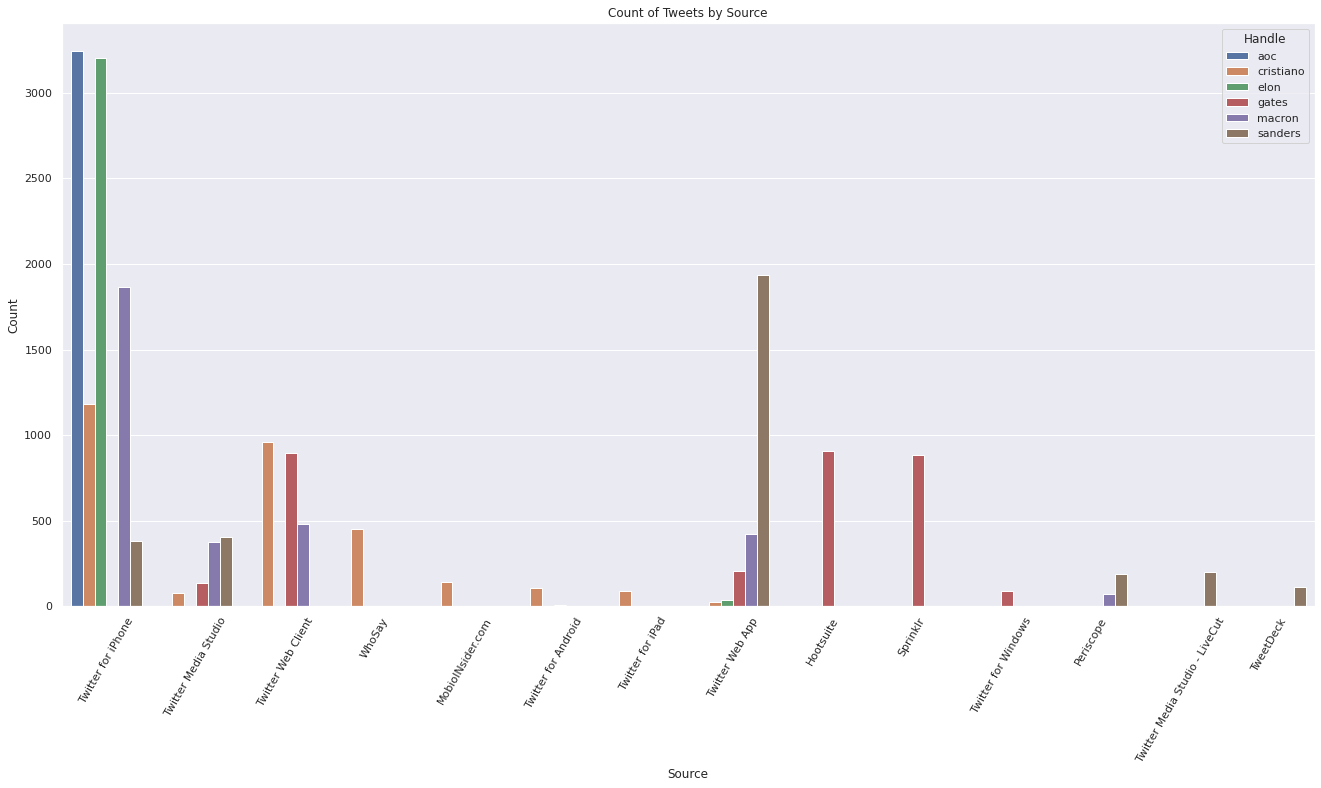

In [7]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=[20,10])
sns.barplot(x = "index", y = "value", hue = "variable", data = device_counts.T.reset_index().melt(id_vars="index"))
plt.xticks(rotation = 60)
plt.title("Count of Tweets by Source")
plt.ylabel("Count")
plt.xlabel("Source")
plt.legend(title="Handle");

- It seems like the most popular choice to use Twitter is through Twitter for iPhone.  
- Bernie Sanders appears to use Twitter Web App way more compared to the other Twitter users.  
- Cristiano Ronaldo has an extensive use of different platforms to tweet from..  
  
    
    

We just looked at the most commonly used devices for each user. However, since we used the number of tweets as a measure, it might be better to compare these distributions by comparing _proportions_ of tweets. Proportions of tweets would be better measures than numbers of tweets because each handle might tweet a different total number of tweets. An extreme case - one person tweets a 100 times but another person 100000 times. That will look differently on a counts bar graph

---
# What time did they tweet that?
Performing some time series analysis, A look into the temporal aspect of the data could reveal insights about how a user spends their day, when they eat and sleep, etc. In this section, I will focus on the time at which each tweet was posted.  
  
The purpose of `add_hour` is to add a new column to each dataframe showing the hour of their tweet (since there is no useful column showing it). In order to add an hour (float) to a tweet, we're going to scrape the time from the `created_at` column, since it shows the date and time a tweet was created

In [8]:
def add_hour(df, time_col = "created_at", result_col = "hour"):
    hour, minute, second = df[time_col].dt.hour, df[time_col].dt.minute, df[time_col].dt.second
    df[result_col] = hour + minute / 60 + second / 60**2
    return df

# adding hour column for each Twitter user
tweets = {handle: add_hour(df) for handle, df in tweets.items()}

# Let's now display what that column looks like ~

tweets['aoc'][['full_text', 'hour']]

,full_text,hour
id,,
1358149122264563712,RT @RepEscobar: Our country has the moral obligation and responsibility to reunite every single family separated at the southern border.\n\nT…,20.377222
1358147616400408576,RT @RoKhanna: What happens when we guarantee $15/hour?\n\n💰 31% of Black workers and 26% of Latinx workers get raises.\n😷 A majority of essent…,20.277500
1358145332316667909,(Source: https://t.co/3o5JEr6zpd),20.126389
1358145218407759875,"Joe Cunningham pledged to never take corporate PAC money, and he never did. Mace said she’ll cash every check she gets. Yet another way this is a downgrade. https://t.co/DytsQXKXgU",20.118611
1358144207333036040,What’s even more gross is that Mace takes corporate PAC money.\n\nShe’s already funded by corporations. Now she’s choosing to swindle working people on top of it.\n\nPeak scam artistry. Caps for cash 💰 https://t.co/CcVxgDF6id,20.051667
...,...,...
1181935928249606146,"Autocrats: “Jump!”\nTrump: “How high?”\n\n- Trump admin foreign policy, 2019",14.238611
1181932554552827905,RT @HeidiNBC: NEW: Donald Trump's decision to remove troops from Northern Syria has put renewed focus on his business and personal relation…,14.015000
1181932460516478976,"Trump decision isn’t about drawing down US military involvement at all. \n\nRemember that earlier this year, Trump VETOED Congress’ attempt to end US involvement in the Yemen War.\n\nHe has significant personal financial conflicts of interest in this situation, among other co...",14.008889


---
Now we have a column that displays the time of the day the tweet was posted, However, to account for different locations of each user in our analysis, we will next adjust the created_at timestamp for each tweet to the respective timezone of each user. (so basically correcting the timezones)

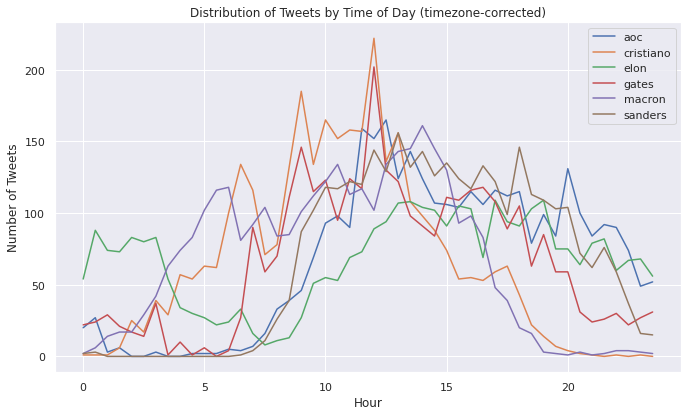

In [9]:
# creating appropriate bins
def bin_df(df, bins, colname):
    binned = pd.cut(df[colname], bins).value_counts().sort_index()
    return pd.DataFrame({"counts": binned, "bin": bins[:-1]})

hour_bins = np.arange(0, 24.5, .5)


# since our Twitter users are located across the world, let's adjust to their respective timezones
def convert_timezone(df, new_tz):
    for account in tweets:
        tweets[account]['converted_time'] = tweets[account]['created_at'].dt.tz_convert(new_tz)
    return df


timezones = {"aoc": "EST", "cristiano": "Europe/Lisbon", "elon": "America/Los_Angeles",
            'gates': 'America/Los_Angeles', 'macron' : 'EST' , 'sanders': 'EST'}

tweets = {handle: convert_timezone(df, tz) for (handle, df), tz in zip(tweets.items(), timezones.values())}



tweets = {handle: add_hour(df, "converted_time", "converted_hour") for handle, df in tweets.items()}
binned_hours = {handle: bin_df(df, hour_bins, "converted_hour") for handle, df in tweets.items()}

make_line_plot(binned_hours, "bin", "counts", title = "Distribution of Tweets by Time of Day (timezone-corrected)",
               xlabel = "Hour", ylabel = "Number of Tweets")

### Analysis:   
The hour x-axis goes from 0 (12:00 am) to 24 (11:59 pm)  
... 

---
# Sentiment Analysis of User's Tweets

---

How do we actually measure the sentiment of each tweet? In our case, we can use the words in the text of a tweet for our calculation! For example, the word "love" within the sentence "I love America!" has a positive sentiment, whereas the word "hate" within the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of AOC's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. These are some rows of the lexicon:

In [10]:
print(''.join(open("tweeters/vader_lexicon.txt").readlines()[:15]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]
(*	1.1	1.13578	[2, 1, 1, -1, 1, 2, 2, -1, 2, 2]
(-%	-0.7	1.26886	[-1, 2, 0, -1, -1, -2, 0, 0, -3, -1]
(-*	1.3	1.26886	[4, 1, 2, 0, 2, -1, 1, 2, 1, 1]
(-:	1.6	0.8	[2, 2, 1, 3, 1, 1, 1, 3, 1, 1]
(-:0	2.8	0.87178	[3, 2, 3, 4, 3, 2, 3, 1, 4, 3]



As you can see, the lexicon contains emojis too! Each row contains a word and the *polarity* of that word, measuring how positive or negative the word is.

### VADER Sentiment Analysis

The creators of VADER describe the tool’s assessment of polarity, or “compound score,” in the following way:

“The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.”

As you can see, VADER doesn't "read" sentences, but works by parsing sentences into words, assigning a preset generalized score from their testing sets to each word separately. 

VADER relies on humans to stabilize its scoring. The creators use Amazon Mechanical Turk, a crowdsourcing survey platform, to train its model. Its training data consists of a small corpus of tweets, New York Times editorials and news articles, Rotten Tomatoes reviews, and Amazon product reviews, tokenized using the natural language toolkit (NLTK). Each word in each dataset was reviewed and rated by at least 20 trained individuals who had signed up to work on these tasks through Mechanical Turk. 

In [11]:
sent = pd.read_csv('tweeters/vader_lexicon.txt', sep = '\t', header = None)
sent = sent.rename(columns = {0 : 'token', 1 : 'polarity'}).drop(axis = 1, labels = [2, 3])
sent = sent.set_index('token')
sent

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7
...,...
}:,-2.1
}:(,-2.0
}:),0.4


---
## Working with Regular Expressions

Using regular expressions, we can parse out specific things we want out of a tweet, whether it's a twitter mention, hashtag, website link, etc. 

In [12]:
punct_re = r'[^\sA-Za-z0-9]' # no letters, no numbers, no underscore, no whitespaces, no tabs, no newline, no carriage return"

mentions_re = r'@(\w+):' # capturing groups of mentions

hashtag_re = r'\s#(\w+)' # originally had (\s|[^\w+])#(\w+) to account for the two conditions but it doesn't work?
# solutions that do work: [^\w+]#(\w+) or \s#(\w+)

weblink_re = r'(https:\/\/www.[\w|.|\/]*|http:\/\/www.[\w|.|\/]*)' 
# (http:\/\/|https:\/\/)www.(\w+.\w+)\/(\w+)+\/'


Some examples below running these regular expressions on AOC's tweets ~

In [13]:
re.findall(mentions_re, tweets["aoc"].iloc[0]["full_text"]) # finds mentions in AOC's tweets

['RepEscobar']

In [14]:
re.search(weblink_re, "a link to https://www.google.com!")

<re.Match object; span=(10, 32), match='https://www.google.com'>

In [15]:
re.findall(hashtag_re, tweets["aoc"].loc[1337426463709073410]["full_text"]) #finds Hashtags in AOC's tweets

['TaxTheRich', 'COVID']

In [16]:
re.sub(punct_re, " ", tweets["aoc"].iloc[0]["full_text"])

'RT  RepEscobar  Our country has the moral obligation and responsibility to reunite every single family separated at the southern border \n\nT '

---
### Tweet Sentiments and User Mentions

As you have seen in the previous part of this question, there are actually a lot of interesting components that we can extract out of a tweet for further analysis! For the rest of this question though, we will focus on one particular case: the sentiment of each tweet in relation to the users mentioned within it. 

To calculate the sentiments for a sentence, we will follow this procedure:

1. Remove the punctuation from each tweet so we can analyze the words.
2. For each tweet, find the sentiment of each word.
3. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

---
## Removing Punctuation
Let's use our `punct_re` regular expression from the previous part to clean up the text a bit more! The goal here is to remove all of the punctuations to ensure words can be properly matched with those from VADER to actually calculate the full sentiment score.

The following function `sanitize_texts` takes in a table `df` and adds a new column `clean_text` by converting all characters in its original full_text column to lower case and replace all instances of punctuations with a space character.

In [17]:
def sanitize_texts(df):
    df["clean_text"] = df['full_text'].str.replace(punct_re, ' ', regex = True).str.lower()
    return df

tweets = {handle: sanitize_texts(df) for handle, df in tweets.items()}

# Let's try it out on elon's tweets
tweets["elon"]["clean_text"].head()

id
1357991946082418690          the second last kingdom https   t co je4ei88hmv
1357973565413367808     dumdin7  grimezsz haven t heard that name in years  
1357972904663687173                                        grimezsz dogecake
1357970517165182979                          yolt\n\nhttps   t co cnof9yjpf1
1357964347813687296                              kristennetten that s damian
Name: clean_text, dtype: object

With the texts sanitized, we can now extract all the user mentions from tweets. 

The function `extract_mentions` takes in the **`full_text` column** from a tweets `DataFrame` and uses `mentions_re` to extract all the mentions in a `pd.Series`. The returned series, renamed to `mentions`, is single-indexed and has all lower-cased characters with a separate row for each mention.

In [18]:
def extract_mentions(full_texts):
    mentions = full_texts.str.lower().str.extractall(mentions_re).reset_index()
    mentions = mentions.rename(columns = {0 : 'mentions'})
    mentions = mentions.set_index('id')
    return mentions[["mentions"]]

mentions = {handle: extract_mentions(df["full_text"]) for handle, df in tweets.items()}
horiz_concat_df(mentions).head()

,aoc,cristiano,elon,gates,macron,sanders
,mentions,mentions,mentions,mentions,mentions,mentions
0,repescobar,appstore,spacex,melindagates,agriskippy,theview
1,rokhanna,iheartrmadridcf,spacex,codeorg,jeancastex,theview
2,jaketapper,pele,spacex,rajpanjabi,jeancastex,cnnsitroom
3,repmcgovern,benzema,spacex,melindagates,francediplo_en,potus
4,joeneguse,arturbanar,spacex,lastmilehealth,ecologie_gouv,allinwithchris


### Tidying Up the Data

Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. We will use the `clean_text` column of each dataframe to create a tidy table, which will be returned by `to_tidy_format`. The index of the table will be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

In [19]:
def to_tidy_format(df):
    tidy = (
        df["clean_text"]
        .str.split()
        .explode()
        .to_frame()
        .rename(columns={"clean_text": "word"})
    )
    return tidy

tidy_tweets = {handle: to_tidy_format(df) for handle, df in tweets.items()}
tidy_tweets["aoc"].head()

,word
id,
1358149122264563712,rt
1358149122264563712,repescobar
1358149122264563712,our
1358149122264563712,country
1358149122264563712,has


## Adding in the Polarity Score

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

The following `add_polarity` function adds a new `polarity` column to the `df` table. The `polarity` column contains the sum of the sentiment polarity of each word in the text of the tweet.

In [20]:
def add_polarity(df, tidy_df):
    df["polarity"] = (
        tidy_df
        .merge(sent, how='left', left_on='word', right_index=True)
        .reset_index()
        .loc[:, ['id', 'polarity']]
        .groupby('id')
        .sum()
        .fillna(0)
    )
    return df

tweets = {handle: add_polarity(df, tidy_df) for (handle, df), tidy_df in \
          zip(tweets.items(), tidy_tweets.values())}
tweets["aoc"][["clean_text", "polarity"]].head()

,clean_text,polarity
id,,
1358149122264563712,rt repescobar our country has the moral obligation and responsibility to reunite every single family separated at the southern border \n\nt,0.0
1358147616400408576,rt rokhanna what happens when we guarantee 15 hour \n\n 31 of black workers and 26 of latinx workers get raises \n a majority of essent,1.0
1358145332316667909,source https t co 3o5jer6zpd,0.0
1358145218407759875,joe cunningham pledged to never take corporate pac money and he never did mace said she ll cash every check she gets yet another way this is a downgrade https t co dytsqxkxgu,0.0
1358144207333036040,what s even more gross is that mace takes corporate pac money \n\nshe s already funded by corporations now she s choosing to swindle working people on top of it \n\npeak scam artistry caps for cash https t co ccvxgdf6id,-6.4


In [21]:
def mention_polarity(df, mention_df):
    new_df = (
        df
        .merge(mention_df, how = 'left', left_on = 'id', right_index = True)
        .reset_index().set_index('mentions')
        .loc[:, ['polarity']]
        .groupby('mentions')
        .mean()
        .fillna(0)
    )
    return new_df['polarity']


aoc_mention_polarity = mention_polarity(tweets["aoc"], mentions["aoc"]).sort_values(ascending=False)
aoc_mention_polarity

mentions
gqmagazine          8.3
bwestbrookaz8       8.1
nobelprize          7.3
thejagmeetsingh     6.5
kumarraonyc         6.4
                   ... 
barbararansby      -6.4
repkarenbass       -6.9
paolamendoza       -7.6
itsgabrielleu      -9.4
scotthech         -10.8
Name: polarity, Length: 630, dtype: float64

In [22]:
tweets.keys()

dict_keys(['aoc', 'cristiano', 'elon', 'gates', 'macron', 'sanders'])

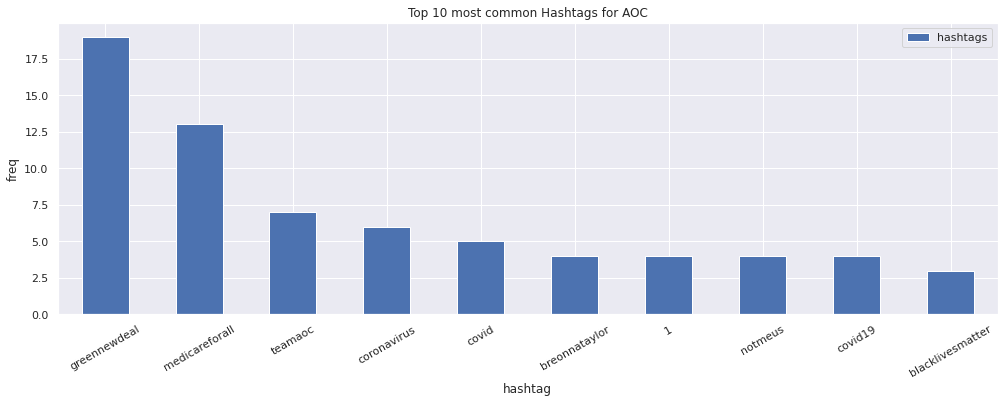

In [23]:


hashtag_re = r'\s#(\w+)' # regex for finding hashtags

def extract_hashtags(full_texts):
    hashtags = full_texts.str.lower().str.extractall(hashtag_re).reset_index()
    hashtags = hashtags.rename(columns = {0 : 'hashtags'})
    hashtags = hashtags.set_index('id')
    return hashtags[["hashtags"]]

hashtags = {handle: extract_hashtags(df["full_text"]) for handle, df in tweets.items()}
hashtags = horiz_concat_df(hashtags)
hashtags

# series of each most frequent hashtags for each account

aoc = most_freq(hashtags['aoc']['hashtags']).to_frame()
cristiano = most_freq(hashtags['cristiano']['hashtags']).to_frame()
elon = most_freq(hashtags['elon']['hashtags']).to_frame()
sanders = most_freq(hashtags['sanders']['hashtags']).to_frame()
macron = most_freq(hashtags['macron']['hashtags']).to_frame()
gates = most_freq(hashtags['gates']['hashtags']).to_frame()


make_bar_plot(aoc, title = 'Top 10 most common Hashtags for AOC', 
              xlabel = 'hashtag', ylabel = 'freq');
plt.xticks(rotation = 30);

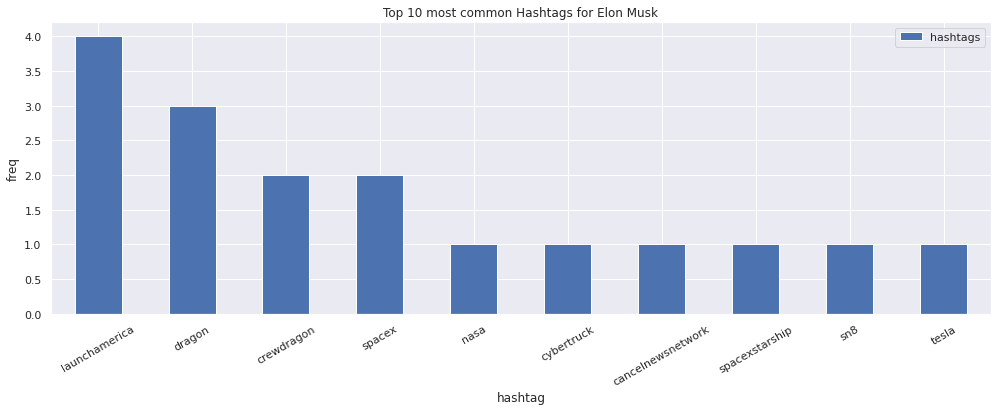

In [24]:
make_bar_plot(elon, title = 'Top 10 most common Hashtags for Elon Musk', 
              xlabel = 'hashtag', ylabel = 'freq');
plt.xticks(rotation = 30);

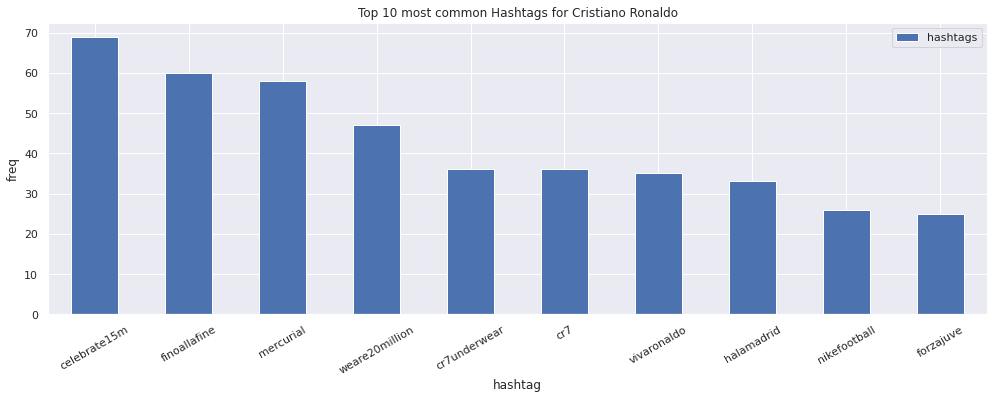

In [25]:
make_bar_plot(cristiano, title = 'Top 10 most common Hashtags for Cristiano Ronaldo',
              xlabel = 'hashtag', ylabel = 'freq');
plt.xticks(rotation = 30);

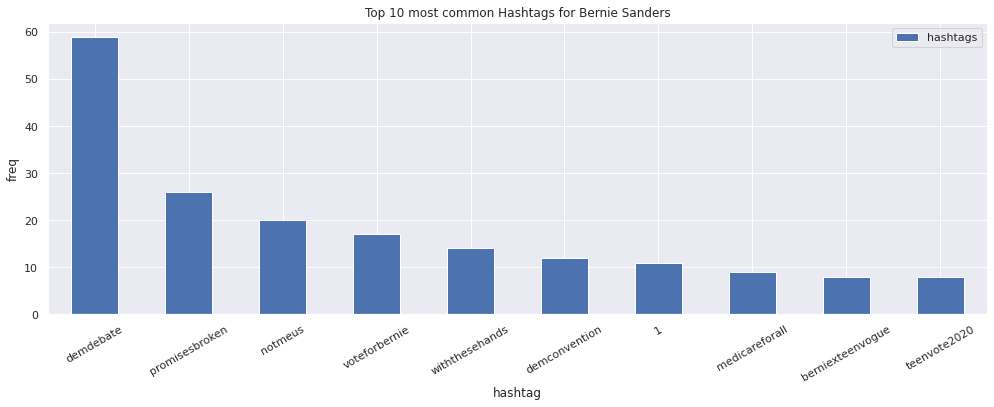

In [26]:
make_bar_plot(sanders, title = 'Top 10 most common Hashtags for Bernie Sanders', 
              xlabel = 'hashtag', ylabel = 'freq');
plt.xticks(rotation = 30);

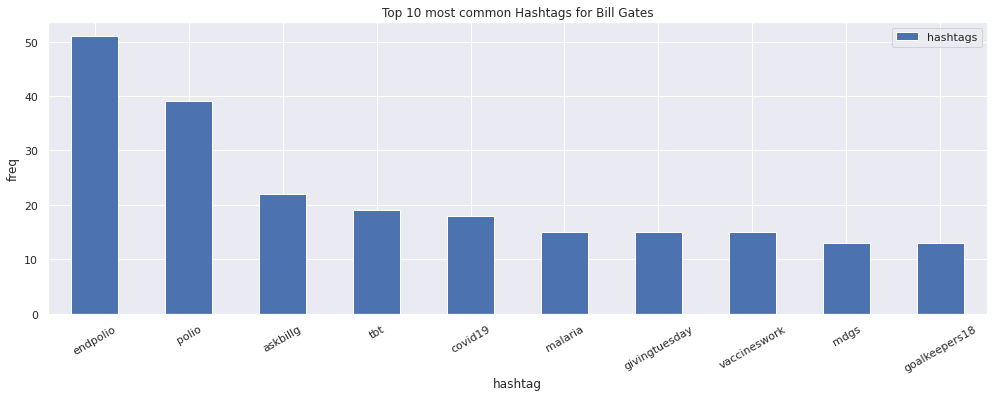

In [27]:
make_bar_plot(gates, title = 'Top 10 most common Hashtags for Bill Gates', 
              xlabel = 'hashtag', ylabel = 'freq');
plt.xticks(rotation = 30);

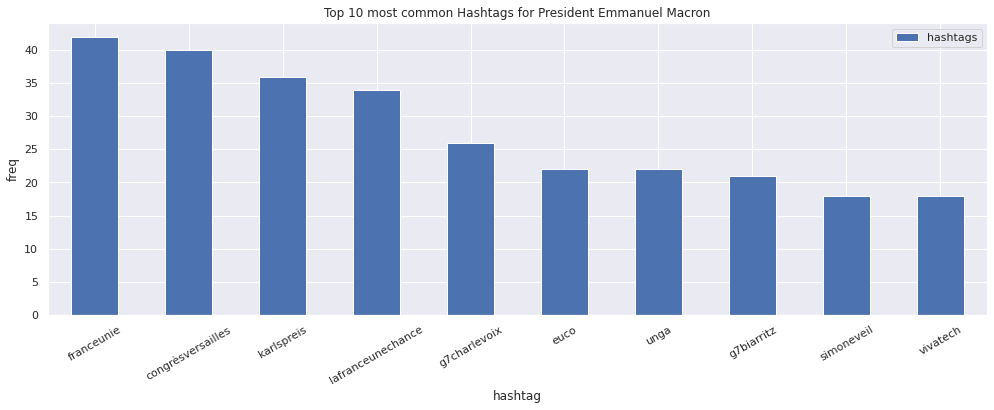

In [28]:
make_bar_plot(macron, title = 'Top 10 most common Hashtags for President Emmanuel Macron', 
              xlabel = 'hashtag', ylabel = 'freq');
plt.xticks(rotation = 30);

## Analysis: 

### P.S! This is V1 of the project... I will continue throughout my semester to add more details for each function and graph I created ~ I'm just busy with midterms currently ;-; 
Some things to work on:
- Figure out a way to add colors to the bar graphs, to make it more visually appealing
- Perform EDA on those bar graphs, dig deep and analyze them individually..  
- Smooth out any discrepancies I had earlier, make the project "flow" from step to step...
- Explore more about the mentions, I found earlier AOC's top mentions (#1 was towards @gqmagazine)... how about the others??? Who are they @'ing?? 
# 🧐🧐🧐